In [1]:
# =====================================================================
# 0. IMPORTS, PATHS & PRESET
# =====================================================================
import os
import re
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset

# directories
CACHE_DIR    = "/tmp/coords_cache"
COMP_DIR     = "/kaggle/input/stanford-rna-3d-folding"
EXT_DIR_UW   = "/kaggle/input/synthetic-rna-rib-uw-datasets"
EXT_DIR_RIBO = "/kaggle/input/dataset"

os.makedirs(CACHE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"RUNNING ON {DEVICE}, GPUs: {torch.cuda.device_count()}")

# =====================================================================
# 1. PRESET → HYPER-PARAMETERS
# =====================================================================
PRESET = "quick"
if PRESET == "quick":
    D_MODEL, NUM_HEADS, TF_LAYERS, EGNN_LAYERS = 64, 2, 2, 2
    BATCH_SIZE, MAX_LEN, NUM_EPOCHS, LR         = 4, 512, 5, 1e-6
elif PRESET == "highacc":
    D_MODEL, NUM_HEADS, TF_LAYERS, EGNN_LAYERS = 96, 12, 6, 6
    BATCH_SIZE, MAX_LEN, NUM_EPOCHS, LR         = 4, 512, 20, 3e-4
else:
    D_MODEL, NUM_HEADS, TF_LAYERS, EGNN_LAYERS = 64, 8, 4, 4
    BATCH_SIZE, MAX_LEN, NUM_EPOCHS, LR         = 6, 512, 10, 3e-4


UW_SAMPLE_COUNT   = 10000  #446034
RIBO_SAMPLE_COUNT = 25000  #124902
DISTOGRAM_BINS    = 64
W_GEO_LOSS        = 0.0
W_SOFT_TM_LOSS    = 1
W_SPREAD_LOSS     = 0.7
W_REGULARIZATION  = 0.2
W_DISTOGRAM       = 0.5



RUNNING ON cuda, GPUs: 2


In [2]:
# =====================================================================
# 2. BUILD C1′ COORDINATE CACHE (once at startup, NaN‐first)
# =====================================================================
import os, re, numpy as np, pandas as pd, pyarrow.parquet as pq
from tqdm import tqdm

def _xyz_cols(cols):
    return sorted(cols, key=lambda c: (int(c.split('_')[1]), 'xyz'.index(c[0])))

def build_cache():
    sources = [
        f"{COMP_DIR}/train_labels.csv",
        f"{COMP_DIR}/train_labels.v2.csv",
        f"{COMP_DIR}/validation_labels.csv",
        f"{EXT_DIR_UW}/ext_labels.parquet",
        f"{EXT_DIR_RIBO}/ext_ribonanza_labels.parquet",
    ]
    for path in sources:
        desc = os.path.basename(path)
        if not os.path.exists(path):
            print(f"→ Skipping {desc}")
            continue

        # load
        if path.endswith(".parquet"):
            df = pq.read_table(path).to_pandas()
        else:
            df = pd.read_csv(path)

        # detect ID column
        id_col = next((c for c in df.columns 
                       if c.lower() in ("id","target_id")), None)
        if id_col is None:
            raise RuntimeError(f"No ID/target_id column in {desc}")

        # split into tid, idx
        df[['tid','idx']] = (
            df[id_col]
              .astype(str)
              .str.rsplit(pat="_", n=1, expand=True)
        )
        df['idx'] = df['idx'].astype(int)

        # pick out xyz columns
        cols = [c for c in df.columns if re.match(r"[xyz]_\d+$", c)]
        cols = _xyz_cols(cols)
        if not cols:
            raise RuntimeError(f"No coordinate columns in {desc}")

        # build and save numpy arrays
        for tid, grp in tqdm(df.groupby("tid"), desc=desc, leave=False):
            arr = grp.sort_values("idx")[cols] \
                     .to_numpy(np.float32) \
                     .reshape(-1, 1, 3)
            # zero NaNs, drop sentinel
            arr = np.nan_to_num(arr, nan=0.0)
            arr[arr < -1e17] = 0.0
            np.save(os.path.join(CACHE_DIR, f"{tid}.npy"),
                    arr, allow_pickle=False)

# only build once
if not os.listdir(CACHE_DIR):
    print("🗄️  Building cache…")
    build_cache()
else:
    print("🗄️  Cache ready:", len(os.listdir(CACHE_DIR)), "files")

cached_ids = {fn[:-4] for fn in os.listdir(CACHE_DIR)
              if fn.endswith(".npy")}
def keep_cached(df):
    return df[df.target_id.isin(cached_ids)] \
             .reset_index(drop=True)


🗄️  Building cache…


In [3]:
# =====================================================================
# 3. DATASETS & DATALOADERS (with per-item NaN → 0 fix)
# =====================================================================
import os, re, numpy as np, pandas as pd, pyarrow.parquet as pq
from torch.utils.data import Dataset, DataLoader
import torch

# one-hot vocab
VOC = {c:i for i,c in enumerate("ACGU")}
VOC["<PAD>"], VOC["<UNK>"] = len(VOC), len(VOC)+1
VOC_SIZE = len(VOC)

def one_hot(seq, max_len):
    M = np.zeros((max_len, VOC_SIZE), np.float32)
    for i,ch in enumerate(seq[:max_len]):
        M[i, VOC.get(ch, VOC["<UNK>"])] = 1.0
    return M

class LazyRNA(Dataset):
    def __init__(self, df, max_len, cache_dir):
        self.df = df.reset_index(drop=True)
        self.max_len, self.cache_dir = max_len, cache_dir

    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        tid, seq = row.target_id, row.sequence
        L = len(seq)
        clip = min(L, self.max_len)

        feat = one_hot(seq, self.max_len)
        feat = torch.from_numpy(feat)

        # load cached coords (zero‐fill NaNs & sentinel)
        try:
            arr = np.load(f"{self.cache_dir}/{tid}.npy", mmap_mode="r")
        except FileNotFoundError:
            arr = np.zeros((self.max_len,1,3), np.float32)
        arr = np.nan_to_num(arr, nan=0.0)
        arr[arr < -1e17] = 0.0
        arr = arr[:self.max_len]

        coords = np.zeros((self.max_len,1,3), np.float32)
        coords[:arr.shape[0]] = arr
        coords = torch.from_numpy(coords)

        mask = torch.arange(self.max_len) < clip
        return tid, feat, coords, mask

def load_and_filter(path, keep_ids):
    df = pd.read_parquet(path) if path.endswith('.parquet') else pd.read_csv(path)
    if 'ID' in df.columns and 'target_id' not in df.columns:
        df = df.rename(columns={'ID':'target_id'})
    return df[df.target_id.isin(keep_ids)].reset_index(drop=True)

# assume CACHE_DIR & COMP_DIR, EXT_DIR_UW, EXT_DIR_RIBO built already...
cached_ids = {fn[:-4] for fn in os.listdir(CACHE_DIR) if fn.endswith(".npy")}

val_df = load_and_filter(f"{COMP_DIR}/validation_sequences.csv", cached_ids)
t1     = load_and_filter(f"{COMP_DIR}/train_sequences.csv",      cached_ids)
try:
    t2 = load_and_filter(f"{COMP_DIR}/train_sequences.v2.csv",  cached_ids)
except FileNotFoundError:
    t2 = pd.DataFrame(columns=['target_id','sequence'])

train_comp = pd.concat([t1,t2],ignore_index=True).drop_duplicates('target_id')
train_comp = train_comp[~train_comp.target_id.isin(val_df.target_id)]

uw = load_and_filter(f"{EXT_DIR_UW}/ext_sequences.parquet", cached_ids)
uw = uw[~uw.target_id.isin(val_df.target_id)].sample(n=min(UW_SAMPLE_COUNT,len(uw)),random_state=42)

ribo = load_and_filter(f"{EXT_DIR_RIBO}/ext_ribonanza_sequences.parquet", cached_ids)
ribo = ribo[~ribo.target_id.isin(val_df.target_id)].sample(n=min(RIBO_SAMPLE_COUNT,len(ribo)),random_state=42)

train_df = pd.concat([train_comp,uw,ribo],ignore_index=True).drop_duplicates('target_id').reset_index(drop=True)

train_loader = DataLoader(LazyRNA(train_df, MAX_LEN, CACHE_DIR),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(LazyRNA(val_df, MAX_LEN, CACHE_DIR),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"TRAIN SIZE: {len(train_df):,}, VAL SIZE: {len(val_df):,}")


TRAIN SIZE: 40,379, VAL SIZE: 12


In [4]:
# =====================================================================
# 3. SANITY CHECK
# =====================================================================
print("\nExample batch from val_loader:")
for tid, feat, coords, mask in val_loader:
    print(" ", feat.shape, coords.shape, mask.sum().item())
    break



Example batch from val_loader:
  torch.Size([4, 512, 6]) torch.Size([4, 512, 1, 3]) 325


In [5]:
# ---------------------------------------------------------------------
# Print out how many rows (i.e. sequences) are in each file
# ---------------------------------------------------------------------
import os
import pandas as pd

# adjust these to your actual paths
COMP_DIR     = "/kaggle/input/stanford-rna-3d-folding"          # competition data
UW_DIR       = "/kaggle/input/synthetic-rna-rib-uw-datasets"   # UW external data
DATASET_DIR  = "/kaggle/input/dataset"                        # your “dataset” folder

def count_rows_in_dir(name, directory):
    print(f"\n{name} ({directory}):")
    for fn in sorted(os.listdir(directory)):
        path = os.path.join(directory, fn)
        if fn.endswith(".csv"):
            df = pd.read_csv(path)
            print(f"  {fn:<30s} → {len(df):,} rows")
        elif fn.endswith(".parquet"):
            df = pd.read_parquet(path)
            print(f"  {fn:<30s} → {len(df):,} rows")
        else:
            print(f"  {fn:<30s} → (not a table)")

count_rows_in_dir("Competition sequences/labels", COMP_DIR)
count_rows_in_dir("UW external data",       UW_DIR)
count_rows_in_dir("Additional dataset",     DATASET_DIR)


# =====================================================================
# 4.  MODEL (Transformer + EGNN + distogram)
# =====================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler




Competition sequences/labels (/kaggle/input/stanford-rna-3d-folding):
  MSA                            → (not a table)
  sample_submission.csv          → 2,515 rows
  test_sequences.csv             → 12 rows
  train_labels.csv               → 137,095 rows
  train_labels.v2.csv            → 3,677,095 rows
  train_sequences.csv            → 844 rows
  train_sequences.v2.csv         → 5,135 rows
  validation_labels.csv          → 2,515 rows
  validation_sequences.csv       → 12 rows

UW external data (/kaggle/input/synthetic-rna-rib-uw-datasets):
  ext_labels.parquet             → 29,757,542 rows
  ext_ribonanza_labels.parquet   → 21,890,650 rows
  ext_ribonanza_sequences.parquet → 124,902 rows
  ext_sequences.parquet          → 446,034 rows

Additional dataset (/kaggle/input/dataset):
  USalign                        → (not a table)
  ext_labels.parquet             → 29,757,542 rows
  ext_ribonanza_labels.parquet   → 21,890,650 rows
  ext_ribonanza_sequences.parquet → 124,902 rows
  ext

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler



In [7]:
# =====================================================================
# 4. MODEL DEFINITION & INITIALIZATION (plain Linear + learned scale)
# =====================================================================
import torch, torch.nn as nn
from torch.cuda.amp import GradScaler

class EGNNLayer(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.edge_mlp  = nn.Sequential(
            nn.Linear(2*d + 1, d), nn.SiLU(), nn.Linear(d, d)
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(d, 1), nn.SiLU()
        )
        self.node_mlp  = nn.Sequential(
            nn.Linear(2*d, d), nn.SiLU(), nn.Linear(d, d)
        )
        self.norm = nn.LayerNorm(d, eps=1e-5)

    def forward(self, h, x, m):
        B,L,_ = x.shape
        xi = x.unsqueeze(2)           # (B,L,1,3)
        xj = x.unsqueeze(1)           # (B,1,L,3)
        dij = (xj - xi).norm(dim=-1, keepdim=True).clamp(min=1e-6)
        hi = h.unsqueeze(2).expand(-1,-1,L,-1)
        hj = h.unsqueeze(1).expand(-1,L,-1,-1)
        e  = self.edge_mlp(torch.cat([hi, hj, dij], dim=-1)).clamp(-10,10)
        shift = self.coord_mlp(e).clamp(-10,10) * (xj - xi).clamp(-10,10)
        mask2 = m.unsqueeze(1).unsqueeze(-1)   # (B,1,L,1)
        x     = x + (shift*mask2).sum(dim=2)
        agg   = (e*mask2).sum(dim=2)
        h     = self.node_mlp(torch.cat([h, agg], dim=-1))
        h     = self.norm(h) * m.unsqueeze(-1)
        return h, x

class RNAFold(nn.Module):
    def __init__(self):
        super().__init__()
        self.inp   = nn.Linear(VOC_SIZE, D_MODEL)
        self.in_norm = nn.LayerNorm(D_MODEL, eps=1e-5)

        self.trf_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=D_MODEL, nhead=NUM_HEADS,
                dim_feedforward=D_MODEL*4, dropout=0.1,
                batch_first=True
            )
            for _ in range(TF_LAYERS)
        ])
        self.trf_norms = nn.ModuleList([
            nn.LayerNorm(D_MODEL, eps=1e-5)
            for _ in range(TF_LAYERS)
        ])

        self.egnn  = nn.ModuleList([EGNNLayer(D_MODEL) for _ in range(EGNN_LAYERS)])

        # coordinate head: tanh + learnable Å scale
        self.out   = nn.Sequential(
            nn.LayerNorm(D_MODEL, eps=1e-5),
            nn.Linear(D_MODEL, 40*3),)
        # initialize to a reasonable Ångström scale:
        self.scale = nn.Parameter(torch.tensor(50.0))  

        self.dist  = nn.Sequential(
            nn.LayerNorm(D_MODEL, eps=1e-5),
            nn.Linear(D_MODEL, DISTOGRAM_BINS)
        )

    def forward(self, f, c, m):
        # f:(B,L,VOC), c:(B,L,1,3), m:(B,L)
        x = c.squeeze(2)                           # (B,L,3)
        h = self.in_norm(self.inp(f)).clamp(-5,5)  # (B,L,D_MODEL)

        for layer,norm in zip(self.trf_layers, self.trf_norms):
            h = layer(h, src_key_padding_mask=~m)
            h = norm(h)

        for eg in self.egnn:
            h, x = eg(h, x, m)

        # coordinate head:
        coords = self.out(h).view(-1, MAX_LEN, 40, 3)
        coords = coords * self.scale     # apply big scale

        # distance‐histogram head:
        dlogits = self.dist(h).clamp(-20,20)
        return coords, dlogits

# instantiate & init
model = RNAFold().to(DEVICE)
for mod in model.modules():
    if isinstance(mod, nn.Linear):
        nn.init.xavier_uniform_(mod.weight)
        if mod.bias is not None:
            nn.init.zeros_(mod.bias)

# disable DataParallel while debugging
# if torch.cuda.device_count()>1:
#     model = nn.DataParallel(model)

scaler = GradScaler()




/tmp/ipykernel_19/2242778923.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [8]:
# =====================================================================
# 5. LOSS FUNCTIONS (no geo, stable spread)
# =====================================================================
import torch
import torch.nn.functional as F

TARGET_STD = 1.0

def spread_penalty(c1, m):
    B,L,_ = c1.shape
    stds = []
    for b in range(B):
        pts = c1[b][m[b]]
        stds.append(
            pts.std(dim=0, unbiased=False).mean()
            if pts.shape[0]>=2 else torch.tensor(0.0, device=c1.device)
        )
    return F.relu(TARGET_STD - torch.stack(stds)).mean()

def soft_tm(p, t, m):
    outs = []
    short = [0.3,0.4,0.5,0.6,0.7]
    for pi, ti, mi in zip(p,t,m):
        L = int(mi.sum().item())
        if L < 2:
            outs.append(pi.new_tensor(0.0))
            continue

        # pick correct d0 scalar, then wrap as a tensor
        if L < 30:
            d0_val = short[min(max((L-12)//4, 0), 4)]
        else:
            d0_val = 1.24 * ((L-15)**(1/3)) - 1.8

        # promote to tensor on same device/dtype as pi
        d0 = pi.new_tensor(d0_val).clamp_min(1e-6)

        d = torch.cdist(pi[:L], ti[:L])                 # (L,L)
        mins = d.min(dim=1).values                      # (L,)
        tm   = (1.0 / (1.0 + (mins / d0)**2 )).mean()   # scalar
        outs.append(1.0 - tm)

    return torch.stack(outs).mean()


def backbone_reg(c1, m):
    d = (c1[:,1:] - c1[:,:-1]).norm(dim=-1)
    ok = m[:,1:] & m[:,:-1]
    return ((d - 3.3)**2 * ok).sum() / ok.sum().clamp_min(1)

BIN_EDGES = torch.linspace(2.0, 50.0, DISTOGRAM_BINS+1, device=DEVICE)

def dist_loss(logits, c1, mask):
    B,L,BIN = logits.shape
    losses = []
    for b in range(B):
        n = int(mask[b].sum())
        if n < 2:
            losses.append(torch.tensor(0.0, device=DEVICE))
            continue

        lp = logits[b][:n]                                    # (n,BIN)
        pair_logits = lp.unsqueeze(1) + lp.unsqueeze(0)       # (n,n,BIN)
        d = torch.cdist(c1[b,:n], c1[b,:n])                   # (n,n)
        idx = torch.bucketize(d, BIN_EDGES).clamp(0,BIN-1)     # (n,n)
        losses.append(
            F.cross_entropy(pair_logits.view(-1,BIN), idx.view(-1))
        )

    return torch.stack(losses).mean()


In [9]:
# =====================================================================
# 6. TRAIN & VALIDATE LOOP (pure FP32)
# =====================================================================
import torch.optim as optim

opt   = optim.Adam(model.parameters(), lr=LR)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_EPOCHS, eta_min=1e-6)
history = {k:[] for k in [
    'train_tm','train_spread','train_reg','train_dist','train_loss',
    'val_tm','val_spread','val_reg','val_dist','val_loss'
]}

for ep in range(1,NUM_EPOCHS+1):
    # Train
    model.train()
    sums = {k:0.0 for k in history if k.startswith('train')}
    for _,feats,coords,mask in train_loader:
        feats,coords,mask = feats.to(DEVICE),coords.to(DEVICE),mask.to(DEVICE)
        coords_pred,dlog = model(feats,coords,mask)
        coords_pred = coords_pred - coords_pred.mean(1,True)
        dlog = dlog.clamp(-20,20)
        c1p = coords_pred[:,:,0,:]
        c1t = coords[:,:,0,:]

        tm   = soft_tm(c1p,c1t,mask)
        sp   = spread_penalty(c1p,mask)
        rg   = backbone_reg(c1p,mask)
        ds   = W_DISTOGRAM * dist_loss(dlog,c1t,mask)

        # clamp NaN/Inf → zero
        tm,sp,rg,ds = [torch.nan_to_num(x,0.0,0.0,0.0) for x in (tm,sp,rg,ds)]
        loss = W_SOFT_TM_LOSS*tm + W_SPREAD_LOSS*sp + W_REGULARIZATION*rg + ds

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),1.0)
        opt.step()

        for name,val in zip(['train_tm','train_spread','train_reg','train_dist','train_loss'],
                            [tm,sp,rg,ds,loss]):
            sums[name] += val.item()
    sched.step()
    n = len(train_loader)
    for k in sums: history[k].append(sums[k]/n)

    # Validate
    model.eval()
    sums = {k:0.0 for k in history if k.startswith('val')}
    with torch.no_grad():
        for _,feats,coords,mask in val_loader:
            feats,coords,mask = feats.to(DEVICE),coords.to(DEVICE),mask.to(DEVICE)
            coords_pred,dlog = model(feats,coords,mask)
            coords_pred = coords_pred - coords_pred.mean(1,True)
            dlog = dlog.clamp(-20,20)
            c1p = coords_pred[:,:,0,:]
            c1t = coords[:,:,0,:]
            tm  = soft_tm(c1p,c1t,mask)
            sp  = spread_penalty(c1p,mask)
            rg  = backbone_reg(c1p,mask)
            ds  = W_DISTOGRAM * dist_loss(dlog,c1t,mask)
            tm,sp,rg,ds = [torch.nan_to_num(x,0.0,0.0,0.0) for x in (tm,sp,rg,ds)]
            loss = W_SOFT_TM_LOSS*tm + W_SPREAD_LOSS*sp + W_REGULARIZATION*rg + ds
            for name,val in zip(['val_tm','val_spread','val_reg','val_dist','val_loss'],
                                [tm,sp,rg,ds,loss]):
                sums[name] += val.item()
    m = len(val_loader)
    for k in sums: history[k].append(sums[k]/m)

    print(f"\nEpoch {ep}/{NUM_EPOCHS}")
    for key in [
        'train_tm','train_spread','train_reg','train_dist','train_loss',
        'val_tm','val_spread','val_reg','val_dist','val_loss'
    ]:
        print(f"  {key:12s}: {history[key][-1]:.4f}")
    print("-"*40)



Epoch 1/5
  train_tm    : 0.6168
  train_spread: 0.0040
  train_reg   : 2.7034
  train_dist  : 2.5283
  train_loss  : 3.6886
  val_tm      : 0.6333
  val_spread  : 0.0000
  val_reg     : 38.0852
  val_dist    : 1.8445
  val_loss    : 10.0948
----------------------------------------

Epoch 2/5
  train_tm    : 0.4734
  train_spread: 0.0015
  train_reg   : 1.7903
  train_dist  : 2.0405
  train_loss  : 2.8730
  val_tm      : 0.5938
  val_spread  : 0.0000
  val_reg     : 15.5883
  val_dist    : 1.6809
  val_loss    : 5.3923
----------------------------------------

Epoch 3/5
  train_tm    : 0.4724
  train_spread: 0.0013
  train_reg   : 1.6192
  train_dist  : 1.9638
  train_loss  : 2.7610
  val_tm      : 0.5797
  val_spread  : 0.0060
  val_reg     : 9.6799
  val_dist    : 1.6269
  val_loss    : 4.1468
----------------------------------------

Epoch 4/5
  train_tm    : 0.4721
  train_spread: 0.0013
  train_reg   : 1.5428
  train_dist  : 1.9482
  train_loss  : 2.7298
  val_tm      : 0.5280
  

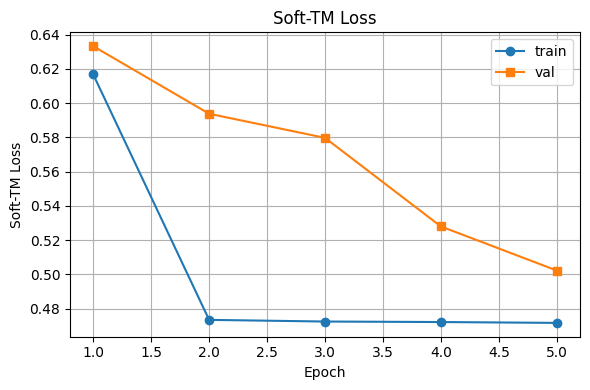

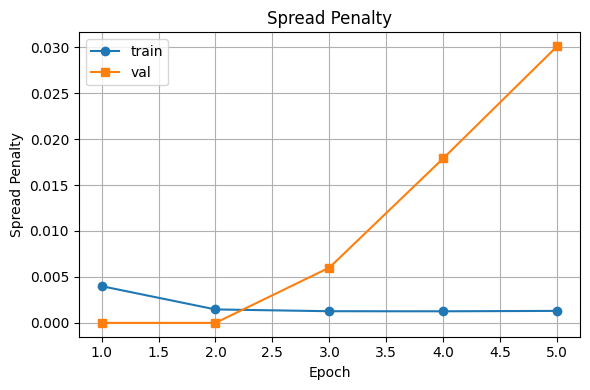

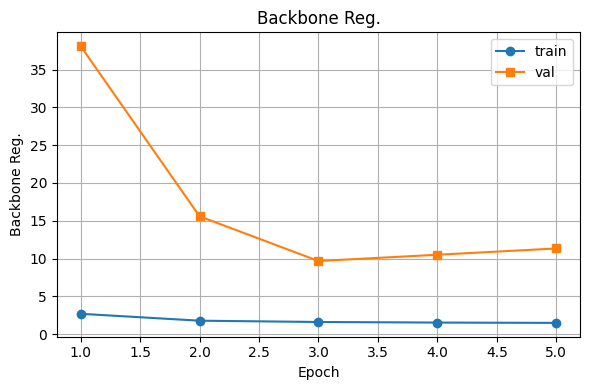

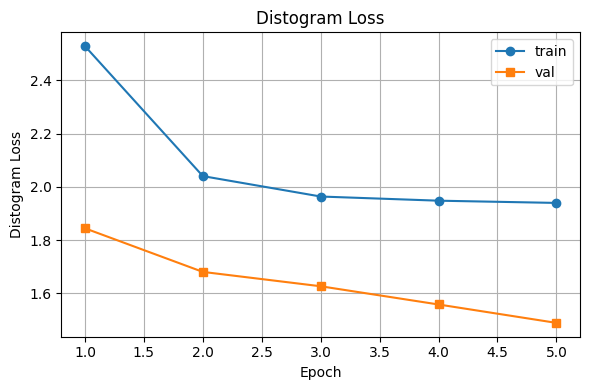

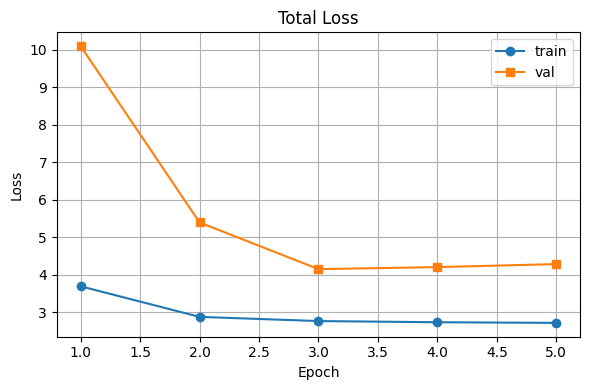

In [10]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(history['train_loss']) + 1))

# --- 1) Individual plots for each loss/metric ---
for metric, ylabel in [
    ('tm',     'Soft-TM Loss'),
    ('spread', 'Spread Penalty'),
    ('reg',    'Backbone Reg.'),
    ('dist',   'Distogram Loss'),
]:
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history[f'train_{metric}'],  '-o', label='train')
    plt.plot(epochs, history[f'val_{metric}'],    '-s', label='val')
    lo = min(history[f'train_{metric}'] + history[f'val_{metric}'])
    hi = max(history[f'train_{metric}'] + history[f'val_{metric}'])
    pad = (hi-lo)*0.05 if hi>lo else lo*0.1
    plt.ylim(lo-pad, hi+pad)
    plt.title(ylabel)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 2) Total loss comparison ---
plt.figure(figsize=(6,4))
plt.plot(epochs, history['train_loss'], '-o', label='train')
plt.plot(epochs, history['val_loss'],   '-s', label='val')
lo = min(history['train_loss'] + history['val_loss'])
hi = max(history['train_loss'] + history['val_loss'])
pad = (hi-lo)*0.05 if hi>lo else lo*0.1
plt.ylim(lo-pad, hi+pad)
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


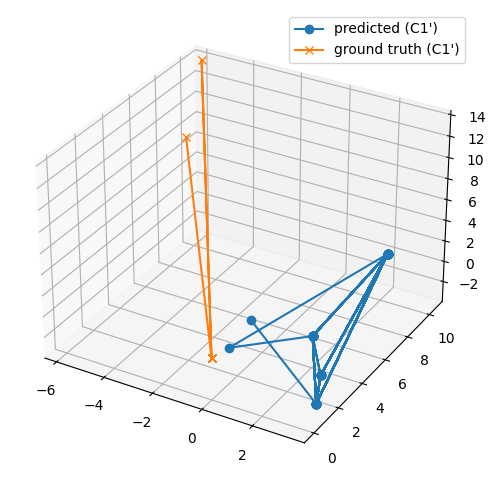

In [11]:
# =====================================================================
# 7. 3D CONNECTED PLOT on first val example (first-5 nts)
# =====================================================================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# grab one batch:
tid, feats, coords, mask = next(iter(val_loader))
feats,coords,mask = feats.to(DEVICE),coords.to(DEVICE),mask.to(DEVICE)
model.eval()
with torch.no_grad():
    preds,_ = model(feats,coords,mask)

# pick the first sequence in batch:
L = int(mask[0].sum().item())
true_seq = coords[0,:L,0,:].cpu().numpy()      # (L,3)
pred_seq = preds[0,:L,0,:].cpu().numpy()       # (L,3)

fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111,projection='3d')
ax.plot(*pred_seq.T, '-o', label='predicted (C1\')')
ax.plot(*true_seq.T, '-x', label='ground truth (C1\')')
ax.legend(); plt.show()



In [12]:
# ---------------
# A1) INFERENCE ON VAL_LOADER
# ---------------
val_ids, val_rows = [], []
model.eval()
with torch.no_grad():
    for tids, feats, coords, mask in val_loader:
        feats, coords, mask = feats.to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)
        preds, _ = model(feats, coords, mask)   # (B, L, 40, 3)
        B, L, A, _ = preds.shape
        for b, tid in enumerate(tids):
            # take only the **first** residue (index 0) and its first 5 atoms → shape (5,3)
            five_xyz = preds[b, 0, :5, :]         # (5,3)
            flat15   = five_xyz.reshape(-1).cpu().tolist()  # length 15
            val_ids.append(tid)
            val_rows.append(flat15)

# ---------------
# A2) MAKE THE DataFrame
# ---------------
cols = []
for i in range(5):
    cols += [f"x{i+1}", f"y{i+1}", f"z{i+1}"]
df_val = pd.DataFrame(val_rows, columns=cols)
df_val.insert(0, "ID", val_ids)


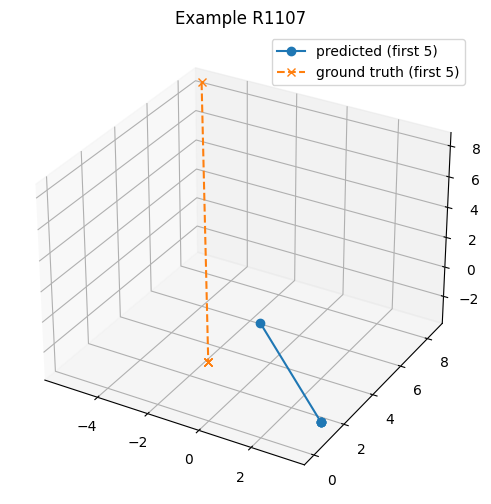

In [13]:
# =======================================================
# Section 8 (snippet): Build true‐coordinate lookup, plot example
# =======================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 1) Run your model on the entire val set and collect the first‐5 predictions
model.eval()
val_preds, val_ids = [], []

with torch.no_grad():
    for tid_batch, feat_batch, coords_batch, mask_batch in val_loader:
        feat_batch = feat_batch.to(DEVICE)
        coords_batch = coords_batch.to(DEVICE)
        mask_batch = mask_batch.to(DEVICE)

        pred_batch, _ = model(feat_batch, coords_batch, mask_batch)
        # pred_batch: (B, L, 40, 3)

        B, L, A, _ = pred_batch.shape
        # take the first structure channel (A=0) and first 5 positions only:
        # shape → (B, L, 3) then [:, :5, :]
        c1_pred = pred_batch[:, :, 0, :]      # (B, L, 3)
        c1_pred5 = c1_pred[:, :5, :]         # (B, 5, 3)

        for b, tid in enumerate(tid_batch):
            # flatten to (5×3,)
            val_preds.append(c1_pred5[b].cpu().numpy().reshape(-1))
            val_ids.append(tid)

# 2) Build true‐coordinate dictionary from val_loader
true_dict = {}
for tid_batch, feat_batch, coords_batch, mask_batch in val_loader:
    # coords_batch: (B, L, 1, 3)
    B, L, _, _ = coords_batch.shape
    for b, tid in enumerate(tid_batch):
        valid_len = int(mask_batch[b].sum().item())
        # take only the real positions and squeeze the middle dim
        true_coords = coords_batch[b, :valid_len, 0, :].cpu().numpy()  # (valid_len, 3)
        true_dict[tid] = true_coords

# 3) Pick one example to plot
example_id = val_ids[0]
pred5      = val_preds[0].reshape(5, 3)
true_all   = true_dict[example_id]  # maybe length >5

# scatter -only first 5, draw them connected
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(
    pred5[:,0], pred5[:,1], pred5[:,2],
    'o-', label='predicted (first 5)'
)
ax.plot(
    true_all[:5,0], true_all[:5,1], true_all[:5,2],
    'x--', label='ground truth (first 5)'
)
ax.set_title(f"Example {example_id}")
ax.legend()
plt.show()


In [14]:
# =====================================================================
# 7. MAKE TEST PREDICTIONS & WRITE submission.csv
# =====================================================================
import pandas as pd
from torch.utils.data import DataLoader

# 1) Load test sequences
test_df = pd.read_csv(f"{COMP_DIR}/test_sequences.csv")

# 2) Build test_loader (coords will be all zeros if no cache)
test_loader = DataLoader(
    LazyRNA(test_df, MAX_LEN, CACHE_DIR),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3) Run model over test_loader and collect the first 5 C1′ predictions
model.eval()
all_ids, all_rows = [], []
with torch.no_grad():
    for tids, feats, coords, mask in test_loader:
        feats, coords, mask = feats.to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)
        preds, _ = model(feats, coords, mask)      # (B, L, 40, 3)
        # take first 5 channels → shape (B, L, 5, 3)
        five = preds[:, :, :5, :].cpu().numpy()     # → (B, L, 5, 3)
        B,L,_,_ = five.shape

        for b in range(B):
            all_ids.append(tids[b])
            # flatten the first-5 coords of length L into a single list [x1,y1,z1,... x5,y5,z5]
            flat = five[b].reshape(-1, 3)[:5]      # (5,3)
            all_rows.append(flat.flatten().tolist())

# 4) Build submission DataFrame    
sub = pd.DataFrame({
    'ID': all_ids,
    **{f'x{i+1}': [row[3*i+0] for row in all_rows] for i in range(5)},
    **{f'y{i+1}': [row[3*i+1] for row in all_rows] for i in range(5)},
    **{f'z{i+1}': [row[3*i+2] for row in all_rows] for i in range(5)},
})

# 5) Write out
sub.to_csv('submission.csv', index=False)
print("→ Wrote submission.csv with", len(sub), "entries.")


→ Wrote submission.csv with 12 entries.


In [15]:
# cleanup
import os, shutil
for fn in os.listdir("/kaggle/working"):
    if fn!="submission.csv":
        p=os.path.join("/kaggle/working",fn)
        (shutil.rmtree(p) if os.path.isdir(p) else os.remove(p))
print("✅ cleaned up.")


✅ cleaned up.
